In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

def read_and_resize_images(img_path1: str, img_path2: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    读取并调整两个图像的大小以匹配第一个图像的尺寸。
    
    Args:
        img_path1 (str): 第一个图像的文件路径。
        img_path2 (str): 第二个图像的文件路径。
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: 调整大小后的两个图像。
    """
    img1 = cv.imread(img_path1)
    img2 = cv.imread(img_path2)
    
    height1, width1 = img1.shape[:2]
    img2 = cv.resize(img2, (width1, height1), interpolation=cv.INTER_AREA)
    
    return img1, img2

# def detect_and_compute_sift_features(img: np.ndarray) -> Tuple[list, np.ndarray]:
#     """
#     使用SIFT算法检测图像中的关键点并计算描述子。
    
#     Args:
#         img (np.ndarray): 输入图像。
    
#     Returns:
#         Tuple[list, np.ndarray]: 关键点和描述子。
#     """
#     sift = cv.SIFT_create()
#     keypoints, descriptors = sift.detectAndCompute(img, None)
#     return keypoints, descriptors

def match_features(describe1: np.ndarray, describe2: np.ndarray) -> list:
    """
    使用FLANN算法匹配两个图像的特征描述子。
    
    Args:
        describe1 (np.ndarray): 第一个图像的描述子。
        describe2 (np.ndarray): 第二个图像的描述子。
    
    Returns:
        list: 优质匹配点对。
    """
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(describe1, describe2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.65 * n.distance:
            good_matches.append(m)
    
    return good_matches

def draw_matches(img1: np.ndarray, kp1: list, img2: np.ndarray, kp2: list, good_matches: list) -> np.ndarray:
    """
    绘制两个图像之间的特征匹配结果。
    
    Args:
        img1 (np.ndarray): 第一个图像。
        kp1 (list): 第一个图像的关键点。
        img2 (np.ndarray): 第二个图像。
        kp2 (list): 第二个图像的关键点。
        good_matches (list): 优质匹配点对。
    
    Returns:
        np.ndarray: 绘制了特征匹配结果的图像。
    """
    matched_img = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None)
    return matched_img

def plot_matches(matched_img: np.ndarray) -> None:
    """
    使用Matplotlib显示特征匹配结果图像。
    
    Args:
        matched_img (np.ndarray): 绘制了特征匹配结果的图像。
    """
    plt.figure(figsize=(15, 10))
    plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
    plt.title('Feature Matches')
    plt.axis('off')
    plt.show()

def match_and_draw_features(img_path1: str, img_path2: str, output_path: Optional[str] = None) -> None:
    """
    读取图像、检测特征、匹配特征，并绘制和显示特征匹配结果。
    
    Args:
        img_path1 (str): 第一个图像的文件路径。
        img_path2 (str): 第二个图像的文件路径。
        output_path (Optional[str]): 保存特征匹配结果图像的文件路径。如果未指定，则不保存。
    """
    img1, img2 = read_and_resize_images(img_path1, img_path2)
    kp1, describe1 = detect_and_compute_sift_features(img1)
    kp2, describe2 = detect_and_compute_sift_features(img2)
    good_matches = match_features(describe1, describe2)
    matched_img = draw_matches(img1, kp1, img2, kp2, good_matches)
    
    if output_path:
        cv.imwrite(output_path, matched_img)
    
    plot_matches(matched_img)

def undistort_and_rotate(image, dist_coeffs, camera_matrix=np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]], dtype=np.float32), angle=0):
    # 读取图像
    image
        # 获取新的相机矩阵
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (image.shape[1], image.shape[0]), 1, (image.shape[1], image.shape[0]))
    
    # 畸变矫正
    undistorted_image = cv.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    
    # 裁剪图像
    x, y, w, h = roi
    undistorted_image = undistorted_image[y:y+h, x:x+w]
    
    # 获取图像中心
    (h, w) = undistorted_image.shape[:2]
    center = (w // 2, h // 2)
    
    # 旋转矩阵
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    
    # 旋转图像并裁剪黑边
    rotated_image = cv.warpAffine(undistorted_image, M, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated_image
    

# 相机矩阵（需要根据具体相机参数调整）
camera_matrix = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]], dtype=np.float32)

# 畸变系数（需要根据具体情况调整）
dist_coeffs_list = [
    np.array([-0.401, 0.59999991, 0, 0], dtype=np.float32),
    np.array([-0.3, 0.2, 0, 0], dtype=np.float32),
    np.array([-0.0733, 0.0833, 0, 0], dtype=np.float32),
    np.array([-0.0733, 0.0833, 0, 0], dtype=np.float32),
    np.array([0.03, 0.00, 0, 0], dtype=np.float32)
]

# 旋转角度（可以根据需要调整）
rotation_angles = [-3.5865, 0, 0, 5]  # 示例角度，可以根据需要调整

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional, List

def read_img(image_path1: str, image_path2: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    读取并返回两张图像。

    参数:
    image_path1 (str): 第一张图像的路径。
    image_path2 (str): 第二张图像的路径。

    返回:
    Tuple[np.ndarray, np.ndarray]: 第一张图像和第二张图像。
    """
    img1 = cv.imread(image_path1)
    img2 = cv.imread(image_path2)
    return img1, img2

def resize_images(img1: np.ndarray, img2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    调整第二张图像的大小以匹配第一张图像的尺寸。

    参数:
    img1 (np.ndarray): 第一张图像。
    img2 (np.ndarray): 第二张图像。

    返回:
    Tuple[np.ndarray, np.ndarray]: 第一张图像和调整大小后的第二张图像。
    """
    
    height1, width1 = img1.shape[:2]
    img2 = cv.resize(img2, (width1, height1), interpolation=cv.INTER_AREA)
    
    return img1, img2

# def detect_and_compute_sift_features(img: np.ndarray) -> Tuple[List[cv.KeyPoint], np.ndarray]:
#     """
#     使用SIFT算法检测图像特征点并计算描述子。

#     参数:
#     img (np.ndarray): 输入图像。

#     返回:
#     Tuple[List[cv.KeyPoint], np.ndarray]: 特征点列表和描述子矩阵。
#     """
#     sift = cv.SIFT_create()
#     keypoints, descriptors = sift.detectAndCompute(img, None)
#     return keypoints, descriptors
def detect_and_compute_sift_features(img: np.ndarray, x_range: List[float] = [0.0, 1.0]) -> Tuple[List[cv.KeyPoint], np.ndarray]:
    """
    使用SIFT算法检测图像特征点并计算描述子，同时只保留指定横坐标范围内的特征点和描述子。

    参数:
    img (np.ndarray): 输入图像。
    x_range (List[float]): 要保留的横坐标范围，取值范围在[0, 1]之间，默认为[0.0, 1.0]表示保留整个图像的特征点。

    返回:
    Tuple[List[cv.KeyPoint], np.ndarray]: 特征点列表和描述子矩阵。
    """
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    if not keypoints or descriptors is None:
        return [], np.array([])

    img_width = img.shape[1]
    x_min = x_range[0] * img_width
    x_max = x_range[1] * img_width

    filtered_keypoints = []
    filtered_descriptors = []

    for kp, desc in zip(keypoints, descriptors):
        if x_min <= kp.pt[0] <= x_max:
            filtered_keypoints.append(kp)
            filtered_descriptors.append(desc)

    filtered_descriptors = np.array(filtered_descriptors)

    return filtered_keypoints, filtered_descriptors


def match_features(describe1: np.ndarray, describe2: np.ndarray) -> List[cv.DMatch]:
    """
    匹配两组图像描述子并筛选出好的匹配。

    参数:
    describe1 (np.ndarray): 第一组描述子。
    describe2 (np.ndarray): 第二组描述子。

    返回:
    List[cv.DMatch]: 筛选出的好的匹配。
    """
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(describe1, describe2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.65 * n.distance]
    
    return good_matches

def match_features2(describe1: np.ndarray, keypoints1: List[cv.KeyPoint], 
                    describe2: np.ndarray, keypoints2: List[cv.KeyPoint], 
                    max_y_diff: float) -> List[cv.DMatch]:
    """
    匹配两组图像描述子并筛选出好的匹配，同时过滤掉纵坐标相差过大的匹配对。

    参数:
    describe1 (np.ndarray): 第一组描述子。
    keypoints1 (List[cv.KeyPoint]): 第一组描述子的关键点。
    describe2 (np.ndarray): 第二组描述子。
    keypoints2 (List[cv.KeyPoint]): 第二组描述子的关键。
    max_y_diff (float): 纵坐标最大允许差异。

    返回:
    List[cv.DMatch]: 筛选出的好的匹配。
    """
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(describe1, describe2, k=2)
    good_matches = []
    
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            # 获取匹配描述子的关键点坐标
            y1 = keypoints1[m.queryIdx].pt[1]
            y2 = keypoints2[m.trainIdx].pt[1]
            x1 = keypoints1[m.queryIdx].pt[0]
            x2 = keypoints2[m.trainIdx].pt[0]
            
            # 过滤掉纵坐标差异过大的匹配对
            if abs(y1 - y2) <= max_y_diff and (x1 > 300 and x2 < 900):
                good_matches.append(m)
    
    return good_matches

def draw_matches(img1: np.ndarray, kp1: List[cv.KeyPoint], img2: np.ndarray, kp2: List[cv.KeyPoint], good_matches: List[cv.DMatch]) -> np.ndarray:
    """
    在两张图像之间绘制匹配的特征点。

    参数:
    img1 (np.ndarray): 第一张图像。
    kp1 (List[cv.KeyPoint]): 第一张图像的特征点。
    img2 (np.ndarray): 第二张图像。
    kp2 (List[cv.KeyPoint]): 第二张图像的特征点。
    good_matches (List[cv.DMatch]): 好的匹配点。

    返回:
    np.ndarray: 绘制了匹配特征点的图像。
    """
    matched_img = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None)
    return matched_img

def plot_matches(matched_img: np.ndarray) -> None:
    """
    显示匹配特征点的图像。

    参数:
    matched_img (np.ndarray): 绘制了匹配特征点的图像。
    """
    plt.figure(figsize=(15, 10))
    plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
    plt.title('Feature Matches')
    plt.axis('off')
    plt.show()

def save_matches(matched_img: np.ndarray, output_path: str) -> None:
    """
    保存匹配特征点的图像。

    参数:
    matched_img (np.ndarray): 绘制了匹配特征点的图像。
    output_path (str): 保存图像的路径。
    """
    cv.imwrite(output_path, matched_img)

def match_and_draw_features(img_path1: str, img_path2: str, output_path: Optional[str] = None) -> None:
    """
    读取图像、检测特征、匹配特征并绘制匹配结果。

    参数:
    img_path1 (str): 第一张图像的路径。
    img_path2 (str): 第二张图像的路径。
    output_path (Optional[str]): 保存匹配结果的路径，如果为None，则不保存。
    """
    img1, img2 = read_and_resize_images(img_path1, img_path2)
    kp1, describe1 = detect_and_compute_sift_features(img1)
    kp2, describe2 = detect_and_compute_sift_features(img2)
    good_matches = match_features(describe1, describe2)
    matched_img = draw_matches(img1, kp1, img2, kp2, good_matches)
    
    if output_path:
        save_matches(matched_img, output_path)
    
    plot_matches(matched_img)

def compute_homography_and_warp(img1: np.ndarray, kp1: List[cv.KeyPoint], img2: np.ndarray, kp2: List[cv.KeyPoint], good_matches: List[cv.DMatch], min_match_count: int = 10) -> Optional[np.ndarray]:
    """
    计算单应性矩阵并将第二张图像变换到第一张图像的平面上。

    参数:
    img1 (np.ndarray): 第一张图像。
    kp1 (List[cv.KeyPoint]): 第一张图像的特征点。
    img2 (np.ndarray): 第二张图像。
    kp2 (List[cv.KeyPoint]): 第二张图像的特征点。
    good_matches (List[cv.DMatch]): 好的匹配点。
    min_match_count (int): 最少匹配点数，默认值为10。

    返回:
    Optional[np.ndarray]: 变换后的图像，如果匹配点不足则返回None。
    """
    if len(good_matches) > min_match_count:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        warp_img = cv.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0]))
        return warp_img
    else:
        print("匹配点不足！")
        return None

def stitch_images(img1: np.ndarray, warp_img: np.ndarray) -> np.ndarray:
    """
    拼接两张图像，使用加权平均的方法处理重叠区域。

    参数:
    img1 (np.ndarray): 第一张图像。
    warp_img (np.ndarray): 变换后的第二张图像。

    返回:
    np.ndarray: 拼接后的图像。
    """
    direct = warp_img.copy()
    direct[0:img1.shape[0], 0:img1.shape[1]] = img1
    rows, cols = img1.shape[:2]
    left, right = 0, cols
    
    for col in range(0, cols):
        if img1[:, col].any() and warp_img[:, col].any():
            left = col
            break
    
    for col in range(cols - 1, 0, -1):
        if img1[:, col].any() and warp_img[:, col].any():
            right = col
            break
    
    res = np.zeros([rows, cols, 3], np.uint8)
    for row in range(0, rows):
        for col in range(0, cols):
            if not img1[row, col].any():
                res[row, col] = warp_img[row, col]
            elif not warp_img[row, col].any():
                res[row, col] = img1[row, col]
            else:
                srcimg_len = float(abs(col - left))
                warpimg_len = float(abs(col - right))
                alpha = srcimg_len / (srcimg_len + warpimg_len)
                res[row, col] = np.clip(img1[row, col] * (1 - alpha) + warp_img[row, col] * alpha, 0, 255)
    
    warp_img[0:img1.shape[0], 0:img1.shape[1]] = res
    return warp_img

def plot_stitched_images(direct: np.ndarray, stitched: np.ndarray) -> None:
    """
    显示拼接后的图像。

    参数:
    direct (np.ndarray): 直接拼接的图像。
    stitched (np.ndarray): 加权平均拼接的图像。
    """
    plt.figure(figsize=(15, 10))
    img3 = cv.cvtColor(direct, cv.COLOR_BGR2RGB)
    plt.imshow(img3)
    plt.title('Direct Stitching')
    plt.show()
    
    plt.figure(figsize=(15, 10))
    img4 = cv.cvtColor(stitched, cv.COLOR_BGR2RGB)
    plt.imshow(img4)
    plt.title('Blended Stitching')
    plt.show()


In [2]:
def pre_process12(img1, img2):
    img1 = undistort_and_rotate(img1, dist_coeffs=np.array([-0.0733, 0.0833,0,0], dtype=np.float32), angle=-2.125)
    img2 = undistort_and_rotate(img2, dist_coeffs=np.array([-0.0733,0.0833,0,0], dtype=np.float32))
    img1 , img2 = resize_images(img1, img2)
    return img1, img2

def pre_process34(img1, img2):
    img1 = undistort_and_rotate(img1, dist_coeffs=np.array([-0.0733, 0.0833, 0, 0], dtype=np.float32), angle=-2)
    img2 = undistort_and_rotate(img2, dist_coeffs=np.array([-0.0733,0.0833,0,0], dtype=np.float32))
    img1 , img2 = resize_images(img1, img2)
    return img1, img2

In [8]:
def read_frame_from_video(video_path: str, frame_number: int) -> np.ndarray:
    """
    从视频文件中读取特定帧。

    参数:
    video_path (str): 视频文件的路径。
    frame_number (int): 需要提取的帧的编号。

    返回:
    np.ndarray: 提取的帧。
    """
    cap = cv.VideoCapture(video_path)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        raise ValueError(f"无法从 {video_path} 提取帧 {frame_number}")
    cap.release()
    return frame

import numpy as np
def crop_image(img: np.ndarray, k: float = 0.1) -> np.ndarray:
    """
    对图像在高度方面裁切掉上下各 k%。

    参数:
    img (np.ndarray): 输入图像。
    k (float): 要裁切掉的百分比（0到1之间）。

    返回:
    np.ndarray: 裁切后的图像。
    """
    height, width = img.shape[:2]
    crop_height = int(height * k)

    # 裁切图像
    cropped_img = img[crop_height:height - crop_height, :]

    return cropped_img

def crop_black_right(image_array):
    # 将图像转换为灰度图以查找黑色像素
    grayscale_image = cv.cvtColor(image_array, cv.COLOR_BGR2GRAY)

    # 查找非黑色区域的边界框
    non_black_pixels = np.where(grayscale_image != 0)
    left, upper = np.min(non_black_pixels, axis=1)
    right, lower = np.max(non_black_pixels, axis=1)

    # 裁剪图像以去除右侧的黑色区域
    cropped_image_array = image_array[10:-10,0:1900]

    return cropped_image_array

# 修改示例代码以使用视频提取帧
video1_path = '../data/testolabc1.avi'
video2_path = '../data/testolabc2.avi'
video3_path = '../data/testolabc3.avi'
video4_path = '../data/testolabc4.avi'
frame_number = 800  # 提取第100帧

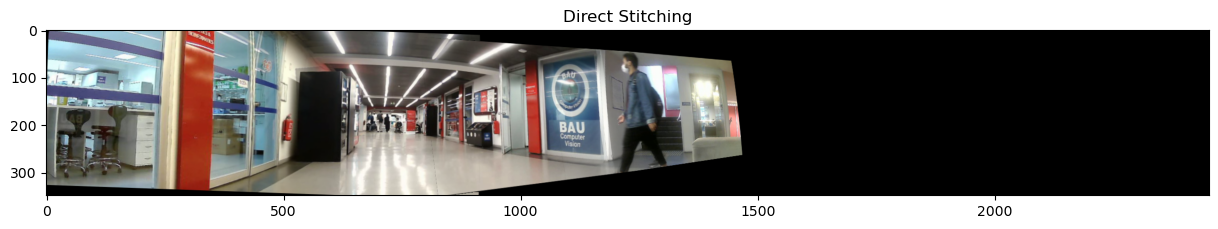

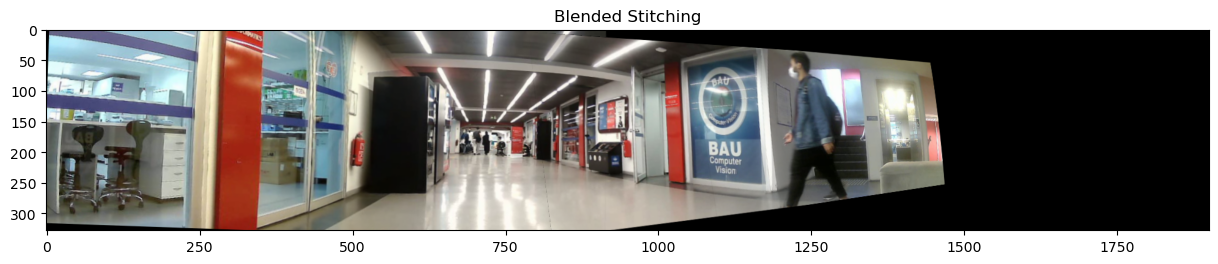

In [19]:
def read_and_preprocess_frames(video_path1, video_path2, frame_number):
    # 读取视频帧
    frame1 = read_frame_from_video(video_path1, frame_number)
    frame2 = read_frame_from_video(video_path2, frame_number)
    
    # 预处理
    preprocessed_frame1, preprocessed_frame2 = pre_process34(frame1, frame2)
    
    return preprocessed_frame1, preprocessed_frame2

def detect_features_and_match(preprocessed_frame1, preprocessed_frame2, range1_for_feature=[0.5, 1], range2_for_feature=[0, 0.5], output_path=None, plot_images=False):
    # 检测和计算SIFT特征
    keypoints1, descriptors1 = detect_and_compute_sift_features(preprocessed_frame1, range1_for_feature)
    keypoints2, descriptors2 = detect_and_compute_sift_features(preprocessed_frame2, range2_for_feature)
    
    # 特征匹配
    good_matches = match_features(descriptors1, descriptors2)
    matched_image = draw_matches(preprocessed_frame1, keypoints1, preprocessed_frame2, keypoints2, good_matches)
    
    # 保存匹配结果
    if output_path:
        save_matches(matched_image, output_path)
    
    # 选择是否绘制匹配结果
    if plot_images:
        plot_matches(matched_image)
    
    return preprocessed_frame1, preprocessed_frame2, keypoints1, keypoints2, good_matches, matched_image
#
#
# def process_and_stitch_frames(video_path1, video_path2, frame_number, output_path, range1_for_feature=[0.5,1],  range2_for_feature= [0,0.5], plot_images=False):
#     # 读取视频帧
#
#     frame1 = read_frame_from_video(video_path1, frame_number)
#     frame2 = read_frame_from_video(video_path2, frame_number)
    
#     # 预处理
#     preprocessed_frame1, preprocessed_frame2 = pre_process34(frame1, frame2)
    
#     # 检测和计算SIFT特征
#     keypoints1, descriptors1 = detect_and_compute_sift_features(preprocessed_frame1, range1_for_feature)
#     keypoints2, descriptors2 = detect_and_compute_sift_features(preprocessed_frame2, range2_for_feature)
    
#     # 特征匹配
#     good_matches = match_features(descriptors1, descriptors2)
#     matched_image = draw_matches(preprocessed_frame1, keypoints1, preprocessed_frame2, keypoints2, good_matches)
    
#     # 保存匹配结果
#     save_matches(matched_image, output_path)
    
#     # 选择是否绘制匹配结果
#     if plot_images:
#         plot_matches(matched_image)
    
#     # 计算单应性并进行图像扭曲
#     warped_image = compute_homography_and_warp(preprocessed_frame1, keypoints1, preprocessed_frame2, keypoints2, good_matches)
#     stitched_image = None
#     if warped_image is not None:
#         stitched_image = stitch_images(preprocessed_frame1, warped_image)
#         if plot_images:
#             plot_stitched_images(direct=warped_image, stitched=stitched_image)
    
#     return stitched_image, warped_image

def compute_features_and_matches(frame1, frame2, range1_for_feature=[0.65, 1], range2_for_feature=[0, 0.2]):
    # 预处理
    preprocessed_frame1 = undistort_and_rotate(frame1, dist_coeffs=np.array([-0.0, 0.2, 0, 0], dtype=np.float32), angle=-2)
    preprocessed_frame2 = undistort_and_rotate(frame2, dist_coeffs=np.array([-0.2, 0.4, 0, 0], dtype=np.float32), angle=-1)
    preprocessed_frame1, preprocessed_frame2 = resize_images(preprocessed_frame1, preprocessed_frame2)
    
    # 检测和计算SIFT特征
    keypoints1, descriptors1 = detect_and_compute_sift_features(preprocessed_frame1, range1_for_feature)
    keypoints2, descriptors2 = detect_and_compute_sift_features(preprocessed_frame2, range2_for_feature)
    
    # 特征匹配
    good_matches = match_features(descriptors1, descriptors2)
    matched_image = draw_matches(preprocessed_frame1, keypoints1, preprocessed_frame2, keypoints2, good_matches)
    
    return preprocessed_frame1, preprocessed_frame2, keypoints1, keypoints2, good_matches, matched_image

def apply_homography_and_stitch(preprocessed_frame1, preprocessed_frame2, keypoints1, keypoints2, good_matches,  plot_images=False):
    
    # 选择是否绘制匹配结果
    # if plot_images:
        # plot_matches(matched_image)
    
    # 计算单应性并进行图像扭曲
    warped_image = compute_homography_and_warp(preprocessed_frame1, keypoints1, preprocessed_frame2, keypoints2, good_matches)
    stitched_image = None
    if warped_image is not None:
        stitched_image = stitch_images(preprocessed_frame1, warped_image)
        stitched_image = crop_black_right(stitched_image)
        if plot_images:
            plot_stitched_images(direct=warped_image, stitched=stitched_image)
    
    return stitched_image, warped_image

# # 调用示例
# stitch_image1, _= process_and_stitch_frames(video1_path, video2_path, 100,  "output.png", range1_for_feature=[0,1], range2_for_feature=[0,0.8], plot_images=False)
# stitch_image2, _= process_and_stitch_frames(video3_path, video4_path, 100, "output2.png", plot_images=False)
# stitch_image1  = crop_image(stitch_image1, k=0.08)
# f1, f2, k1, k2, gm, _ = compute_features_and_matches(stitch_image1, stitch_image2)
# outpu = apply_homography_and_stitch(f1, f2, k1, k2, gm, plot_images=True)
# 读取和预处理视频帧
preprocessed_frame1, preprocessed_frame2 = read_and_preprocess_frames(video1_path, video2_path, 860)
preprocessed_frame3, preprocessed_frame4 = read_and_preprocess_frames(video3_path, video4_path, 860)

# 检测特征和匹配
f1, f2, k1, k2, gm1, _ = detect_features_and_match(preprocessed_frame1, preprocessed_frame2, range1_for_feature=[0, 1], range2_for_feature=[0, 0.8], output_path="output.png", plot_images=False)
f3, f4, k3, k4, gm2, _ = detect_features_and_match(preprocessed_frame3, preprocessed_frame4, plot_images=False)

# 拼接第一组图像
stitched_image1, _ = apply_homography_and_stitch(f1, f2, k1, k2, gm1, plot_images=False)
stitched_image1 = crop_image(stitched_image1, k=0.08)

# 拼接第二组图像
stitched_image2, _ = apply_homography_and_stitch(f3, f4, k3, k4, gm2, plot_images=False)

# 最后拼接两组图像
f1, f2, k1, k2, gm, _ = compute_features_and_matches(stitched_image1, stitched_image2)
final_output = apply_homography_and_stitch(f1, f2, k1, k2, gm, plot_images=True)